In [1]:
from keras import backend as K
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints

from gensim.models import KeyedVectors

from keras.models import Model
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, Dropout

import pandas as pd
import numpy as np
import re

from keras.preprocessing import text, sequence


import numpy as np
import pandas as pd
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

np.random.seed(7)


Using TensorFlow backend.


## Build Bi-LSTM with Attention:

In [0]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim

## Focal Loss for Multi-label classification:

In [0]:
def focal_loss(gamma=2., alpha=.25):
  def focal_loss_fixed(y_true, y_pred):
    pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
    pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
    
    return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
  
  return focal_loss_fixed

## Bi-LSTM Model:

In [0]:
def BidLstm(maxlen, max_features, embed_size, embedding_matrix):
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size, weights=[embedding_matrix],
                  trainable=False)(inp)
    x = Bidirectional(LSTM(300, return_sequences=True, dropout=0.25,
                           recurrent_dropout=0.25))(x)
    x = Attention(maxlen)(x)
    x = Dense(256, activation="relu")(x)
    x = Dropout(0.25)(x)
    x = Dense(25, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)

    return model

## Preprocess the dataset:

In [0]:
#-- Preprocess the text
def preprocess_tweet(text):  
  text=re.sub('rt','', text)
  text = re.sub(' +', ' ', text)  # remove extra whitespace
  text = re.sub('@[^\s]+', '.', text) #remove username
  text = re.sub(r"http\S+", "", text) # remove url
  
  text=re.sub(' +', ' ',text) # replace more than one space with one space
  text = text.strip()  # remove whitespaces
  
  return text

In [0]:
max_features=20000
maxlen=25 # number of classes
embed_size = 300

max_seq_length=128


In [0]:
data_df = pd.read_csv('trec_data.csv')
data_df = data_df.sample(frac=1) # to randomly shuffle the dataset
    
data_df=data_df[['Unnamed: 0_x', 'text','categories']]
data_df.columns = ['id', 'text', 'categories']

data_df.dropna(inplace=True)
    
#preprocess and clean up tweets text.
list_sentences_train = data_df['text'].tolist()    
list_sentences_train = [preprocess_tweet(tweet.lower()) for tweet in list_sentences_train] # preprocess the text
list_sentences_train = [' '.join(t.split()[0:max_seq_length]) for t in list_sentences_train]
    
#preprocess data labels:    
all_labels = data_df['categories'].tolist()
y=np.asarray([ [ x.strip() for x in item[1:-1].split(',')] for item in all_labels])
        
#encode multi-label classes
multilabel_binarizer = MultiLabelBinarizer()

y = multilabel_binarizer.fit_transform(y)
     

tokenizer = text.Tokenizer(num_words=max_features)
    
tokenizer.fit_on_texts(list_sentences_train)
    
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
        
X_t = sequence.pad_sequences(list_tokenized_train, maxlen=maxlen)   
word_index = tokenizer.word_index    

## Using Crisis_Word_Embedding as Feature:

In [0]:
!wget https://crisisnlp.qcri.org/data/lrec2016/crisisNLP_word2vec_model_v1.2.zip
!unzip crisisNLP_word2vec_model_v1.2.zip
!rm crisisNLP_word2vec_model_v1.2.zip
!rm -r __MACOSX

In [0]:
def make_crisis_word2vec(model_path, max_features, embed_size, word_index):
  #-- Load pre-trained model--  
  crisis_word2vec=KeyedVectors.load_word2vec_format(model_path, binary=True) 

 
  nb_words = min(max_features, len(word_index))  
  embedding_matrix = np.zeros((nb_words, embed_size))
  
  for word, i in word_index.items():
    
    if i >= max_features:
      continue
      
    if word in crisis_word2vec.vocab:
      embedding_matrix[i] = crisis_word2vec[word]  
  
  return embedding_matrix
  

In [0]:
max_features=22885
maxlen=25
embed_size = 300

xtr, y, word_index = make_df("all_events.csv", max_features, maxlen)

embedding_vector = make_crisis_word2vec( "crisisNLP_word2vec_model/crisisNLP_word_vector.bin", max_features, embed_size, word_index)


## Using Glove Embedding as Feature:

In [0]:
!wget http://nlp.stanford.edu/data/glove.840B.300d.zip
!unzip glove.840B.300d.zip
!rm glove.840B.300d.zip

In [0]:
def make_glovevec(glovepath, max_features, embed_size, word_index, veclen=300):
    embeddings_index = {}
    f = open(glovepath)
    for line in f:
        values = line.split()
        word = ' '.join(values[:-300])
        coefs = np.asarray(values[-300:], dtype='float32')
        embeddings_index[word] = coefs.reshape(-1)
    f.close()

    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.zeros((nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix


In [0]:
embedding_vector = make_glovevec("glove.840B.300d.txt",
                                 max_features, embed_size, word_index)


## Sampling the Training dataset using RandomOversample:

In [0]:
##X_train, X_test, y_train, y_test = train_test_split(X_t, y, test_size=0.20)

#-- Balancing the dataset --
from imblearn.over_sampling import RandomOverSampler

#from sklearn.model_selection import StratifiedKFold
X_train, X_test, y_train, y_test = train_test_split(X_t, y, test_size=0.20)

#-- Sampling the training data only! --
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_sample(X_train, y_train)



In [14]:
print (X_train.shape)

(95200, 25)


## Model Training:

In [15]:
model = BidLstm(maxlen, max_features, embed_size, embedding_vector)
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
file_path = ".model.hdf5"

ckpt = ModelCheckpoint(file_path, monitor='val_loss', verbose=1,save_best_only=True, mode='min')

early = EarlyStopping(monitor="val_loss", mode="min", patience=1)


history=model.fit(X_train, y_train, batch_size=256, epochs=50, validation_split=0.1, callbacks=[ReduceLROnPlateau(), ckpt, early])


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 85680 samples, validate on 9520 samples
Epoch 1/50
85680/85680 [==============================] - 36s 422us/step - loss: 0.1658 - acc: 0.9587 - val_loss: 0.2968 - val_acc: 0.9600

Epoch 00001: val_loss improved from inf to 0.29675, saving model to .model.hdf5
Epoch 2/50
85680/85680 [==============================] - 35s 404us/step - loss: 0.1111 - acc: 0.9693 - val_loss: 0.3273 - val_acc: 0.9671

Epoch 00002: val_loss did not improve from 0.29675


## Model Evaluation: Accuracy and F1-score (micro):

In [16]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print ("Testing Accuracy:  {:.4f}".format(accuracy), "Testing Loss: {:.4f}".format(loss))

#print ('F1-score', f1_score(y_true=y_test, y_pred=y_pred.round(), average='micro'))

Testing Accuracy:  0.9119 Testing Loss: 0.3257


In [0]:
y_pred=model.predict(X_test)

In [20]:
y_pred2= (y_pred > 0.0)

print (f1_score(y_true=y_test, y_pred=y_pred2, average='micro'))

0.16064354133730122


## Plot Training and Validation Accuracy and Loss:

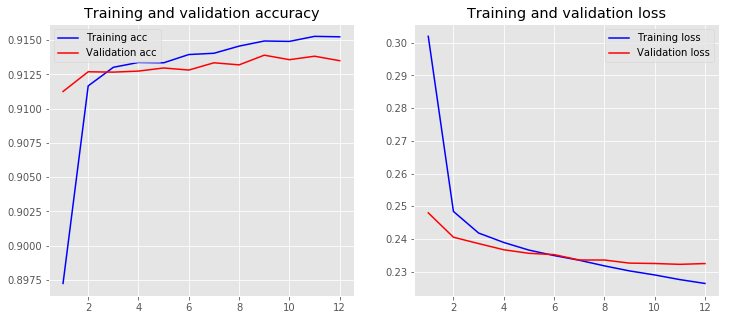

In [31]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

plot_history(history)    

# Generate Submission Report:

In [21]:
#-- get predicted_labels for Bohol Earthquake 2013
Bohol_df=pd.read_csv('trecis2019-A-test.earthquakeBohol2013.csv', index_col='tweet_id')
Bohol_df = Bohol_df[['Text']]
Bohol_df.head()

,Text
tweet_id,
389908166353231872,"Earthquake in Iloilo, Philippines! My head's a..."
389909609190006784,RT @LastQuake: NEW: Felt #earthquake M7.0 - Bo...
389910137676107776,"RT @NewEarthquake: 7.2 earthquake, 2km S of Nu..."
389910670361100288,RT @gmanews: JUST IN: Magnitude 7.2 earthquake...
389911173665001472,"RT @NewEarthquake: 7.2 earthquake, 2km S of Nu..."


## Preprocess the test event:

In [0]:
test_text = [preprocess_tweet(tweet.lower()) for tweet in Bohol_df['Text'].tolist()]
test_text = [' '.join(t.split()[0:max_seq_length]) for t in test_text]
test_id=Bohol_df.index.tolist()


In [0]:
tokenizer.fit_on_texts(test_text)

list_tokenized_train = tokenizer.texts_to_sequences(test_text)
X_t = sequence.pad_sequences(list_tokenized_train, maxlen=maxlen)   
word_index = tokenizer.word_index

# predict labels for the test event:
y_preds=model.predict(X_t)
y_preds_binarized=( y_preds > 0.1)

named_cateogries=multilabel_binarizer.inverse_transform(y_preds_binarized)

In [0]:
Bohol_df['Predicted_Information_Types']=named_cateogries
Bohol_df=Bohol_df[['Predicted_Information_Types']]
Bohol_df.to_csv('Bi-LSTM_submission.earthquakeBohol2013.csv', index_label='tweet_id')

In [26]:
for cateogrie in named_cateogries:
  print (cateogrie)

("'Donations'", "'EmergingThreats'", "'Irrelevant'")
("'ContinuingNews'", "'Irrelevant'", "'Sentiment'")
()
("'Factoid'", "'MultimediaShare'", "'ThirdPartyObservation'")
()
("'Factoid'", "'MultimediaShare'", "'ThirdPartyObservation'")
()
()
()
("'ThirdPartyObservation'",)
()
("'EmergingThreats'", "'MultimediaShare'", "'ServiceAvailable'")
("'FirstPartyObservation'",)
("'ContinuingNews'", "'MultimediaShare'")
("'ThirdPartyObservation'",)
("'Factoid'",)
("'FirstPartyObservation'",)
("'MultimediaShare'",)
("'Donations'", "'MultimediaShare'", "'Sentiment'", "'ServiceAvailable'")
("'EmergingThreats'", "'MultimediaShare'", "'ServiceAvailable'")
()
("'EmergingThreats'", "'MultimediaShare'")
("'EmergingThreats'",)
("'EmergingThreats'", "'MultimediaShare'")
()
("'Irrelevant'", "'MultimediaShare'", "'ServiceAvailable'")
("'Factoid'", "'MultimediaShare'", "'ServiceAvailable'")
("'MultimediaShare'",)
("'SearchAndRescue'",)
()
()
()
()
()
()
("'EmergingThreats'", "'MultimediaShare'")
("'EmergingThr